In [44]:
import os
import mne 
import numpy as np
import pandas as pd
from scipy.signal import resample
import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
p = dict()

# set data path
p['data_folder']         =   os.getcwd()+'\\'+'human'

p['subjects']  = ['15']

p['fs'] = 1000

# set filter parameters
#'delta','theta','alpha','sigma','beta','gama','normal'(0-50Hz)
p['freq_band']      =   'normal'
    
# set domain for filtering
#'tim','freq'
p['filter_extract'] =   'freq'

# set electrode positions
p['channel']        =   ['FZ', 'FC5','FC1','FC2','FC6','CP5','CP1','CP2','CP6','P3','P4','PZ','CZ','OZ','PO7','PO8']

# set EEG epoch length (sec)
p['epoch_len']      =   10

# set total data duration (min or 'NA')
p['duration']       =   6

    
# set features 
#['absolute_power','relative_power','slow_fast','frequency amplitude asymmetry','phase synchrony','coherence','hjorth','spectral_entropy','phase amplitude coupling']
p['features']=['absolute_power','relative_power','slow_fast','frequency amplitude asymmetry','phase synchrony','coherence','hjorth','spectral_entropy','phase amplitude coupling']

# set maximum number of features to be considered for final ML
p['max_features']=20


In [ ]:
quiet = {}
white_noise={}
babble = {}
for i in p['subjects']:
    print("Subject : ",i)
    
    temp=set(p['channel'])
    
    quite_raw = mne.io.read_raw_cnt(os.getcwd()+'\\'+'Data'+'\\'+i+'\\'+'EEG'+i+'_quiet.cnt')
    index = [i for i, val in enumerate(quite_raw.ch_names) if val in temp]
    quite_raw = quite_raw[:, :][0]    
    quiet[i] = (quite_raw[index,:])

    white_noise_raw = mne.io.read_raw_cnt(os.getcwd()+'\\'+'Data'+'\\'+i+'\\'+'EEG'+i+'_noise.cnt')
    index = [i for i, val in enumerate(white_noise_raw.ch_names) if val in temp]
    white_noise_raw = white_noise_raw[:, :][0]
    white_noise[i] = (white_noise_raw[index,:])

    babble_raw = mne.io.read_raw_cnt(os.getcwd()+'\\'+'Data'+'\\'+i+'\\'+'EEG'+i+'_babble.cnt')
    index = [i for i, val in enumerate(babble_raw.ch_names) if val in temp]
    babble_raw = babble_raw[:, :][0]    
    babble[i] = (babble_raw[index,:])

In [ ]:
def resample_data(eeg_data, old_sampling_rate, new_sampling_rate):
    
    resampled_data={}
    for sub in eeg_data:
        data=eeg_data[sub]
        # Total duration in seconds (samples / sampling_rate)
        duration = data.shape[1] / old_sampling_rate
        
        # Number of samples in the resampled data
        new_num_samples = int(duration * new_sampling_rate)
        
        # Resample each row from 3014000 to new number of samples
        resampled_data[sub] = np.zeros((data.shape[0], new_num_samples))  # Initialize resampled matrix
        
        # Loop through each channel and resample
        for i in range(data.shape[0]):
            resampled_data[sub][i, :] = resample(data[i, :], new_num_samples)

    return resampled_data


In [ ]:
quiet_resample = resample_data(quiet, p['fs'], 200)
white_noise_resample = resample_data(white_noise, p['fs'], 200)
babble_resample = resample_data(babble, p['fs'], 200)
p['fs']=200

In [ ]:
def create_epoch(data,p):
    epoch_data = {}
    for ele in data:
        # calculate number of epochs based on epoch length and sampling frequency
        num_epoch = int(np.shape(data[ele])[1]/(p['epoch_len']*p['fs']))
        a=[]
        
        # divide data into epochs
        for i in range(num_epoch):
            a.append(data[ele][:,i*p['fs']*p['epoch_len']:i*p['fs']*p['epoch_len']+p['fs']*p['epoch_len']])

        # transpose data into shape (ele x samples x epochs)
        epoch_data[ele] = np.transpose(a, (1, 2, 0))
        
    return epoch_data

In [ ]:
print('Creating epochs of length '+str(p['epoch_len'])+' sec..............')
quiet_epoch  =    create_epoch(quiet_resample,p)
white_noise_epoch  =    create_epoch(white_noise_resample,p)
babble_epoch  =    create_epoch(babble_resample,p)

In [ ]:
from Artifact_removal import artifact_removal

In [ ]:
print('Removing human epochs with artifacts.......')
quiet_AR,min_quiet,quiet_mask     =    artifact_removal(quiet_epoch,p)
white_noise_AR,min_white_noise,white_noise_mask     =    artifact_removal(white_noise_epoch,p)
babble_AR,min_babble,babble_mask     =    artifact_removal(babble_epoch,p)

min_dur_human=int(min(min_quiet,min_white_noise,min_babble)*p['epoch_len']/60)
print('Minimum duration human '+str(min_dur_human)+' min')
print()



In [ ]:
from Frequency_filtering import freq_filt

In [ ]:
p['freq_band']      =   'normal'
print('Filtering epochs in '+p['freq_band']+' range ............')
quiet_fil  =    freq_filt(quiet_AR,p)
white_noise_fil  =    freq_filt(white_noise_AR,p)
babble_fil  =    freq_filt(babble_AR,p)


In [ ]:
from Spectral_features import feature_spectral

In [ ]:
print('Calculating spectral features.........')
quiet_fil_data_human,quiet_BP_human,quiet_RP_human,quiet_SF_human,quiet_spec_ent_human,quiet_FAA_human,quiet_PAC_human  =    feature_spectral(quiet_fil,p)
white_noise_fil_data_human,white_noise_BP_human,white_noise_RP_human,white_noise_SF_human,white_noise_spec_ent_human,white_noise_FAA_human,white_noise_PAC_human  =    feature_spectral(white_noise_fil,p)
babble_fil_data_human,babble_BP_human,babble_RP_human,babble_SF_human,babble_spec_ent_human,babble_FAA_human,babble_PAC_human  =    feature_spectral(babble_fil,p)


In [ ]:
from Connectivity_features import feature_connectivity

In [ ]:
# choose frequency bands of interest 
freq_band=['delta','theta','alpha','sigma','beta','gama']

In [ ]:
print('Calculating connectivity features human.........')
quiet_coh_human,quiet_phase_syn_human  =    feature_connectivity(quiet_fil,p,quiet_fil_data_human,freq_band)
white_noise_coh_human,white_noise_phase_syn_human  =    feature_connectivity(white_noise_fil,p,white_noise_fil_data_human,freq_band)
babble_coh_human,babble_phase_syn_human  =    feature_connectivity(babble_fil,p,babble_fil_data_human,freq_band)
# [F4_F3,C3_F3,C3_F4,C4_F3,C4_F4,C4_C3,O1_F3,O1_F4,O1_C3,O1_C4,O2_F3,O2_F4,O2_C3,O2_C4,O2_O1]

In [ ]:
from Nonlinear_features import feature_nonlin

In [ ]:
print('Calculating Non-linear features human...........')
Activity_quiet_human,Mobility_quiet_human,Complexity_quiet_human  =    feature_nonlin(quiet_fil_data_human,p,freq_band)
Activity_white_noise_human,Mobility_white_noise_human,Complexity_white_noise_human  =    feature_nonlin(white_noise_fil_data_human,p,freq_band)
Activity_babble_human,Mobility_babble_human,Complexity_babble_human  =    feature_nonlin(babble_fil_data_human,p,freq_band)


In [ ]:
from Create_table import create_table

In [ ]:
def create_table(Control_BP_human,Control_RP_human,Control_SF_human,Control_spec_ent_human,Control_FAA_human,Control_PAC_human,Activity_Control_human,Mobility_Control_human,Complexity_Control_human,Control_human,freq_band,p,*args):
    """consolidate all dictionaries into a dataframe for each subject

    Args:
        Control_BP_human (dictionary): average power
        Control_RP_human (dictionary): relative power
        Control_SF_human (dictionary): power ratios
        Control_spec_ent_human (dictionary): spectral entropy
        Control_FAA_human (dictionary): frequency amplitude asymmetry
        Control_PAC_human (dictionary): phase amplitude coupling
        Activity_Control_human (dictionary): Activity
        Mobility_Control_human (dictionary): Mobility
        Complexity_Control_human (dictionary): Complexity
        Control_human (list): list of subject ID
        freq_band (string): list of frequency bands
        Control_sleep_label (dictionary): corresponding labels
        p (dictionary): contains all parameters of the dataset

    Returns:
        dictionary: dataframe for each subject
    """

    Control_coh_human  = args[0]
    Control_phase_syn_human = args[1]
        
    datfrm = {}
    for i in Control_human:
        
        datfrm[i]=pd.DataFrame({})
        
        if 'absolute_power' in p['features']:
            for j in range(len(freq_band)):
                for k in range(len(p['channel'])):
                    datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                        freq_band[j]+'_power_'+p['channel'][k]:np.log10(Control_BP_human[i][j,k,:]),
                        'alpha1'+'_power_'+p['channel'][k]:np.log10(Control_BP_human[i][6,k,:]),
                        'alpha2'+'_power_'+p['channel'][k]:np.log10(Control_BP_human[i][7,k,:]),
                    })], axis=1)
        
        if 'relative_power' in p['features']:
            for j in range(len(freq_band)):
                for k in range(len(p['channel'])):
                    datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                        freq_band[j]+'_rel_power_'+p['channel'][k]:np.log10((Control_RP_human[i][j,k,:])/(1-(Control_RP_human[i][j,k,:])))
                    })], axis=1)

        if 'hjorth' in p['features']:
            for j in range(len(freq_band)):
                for k in range(len(p['channel'])):
                    datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                        freq_band[j]+'_activity_hjorth_'+p['channel'][k]:Activity_Control_human[freq_band[j]][i][k],
                        freq_band[j]+'_mobility_hjorth_'+p['channel'][k]:Mobility_Control_human[freq_band[j]][i][k],
                        freq_band[j]+'_complexity_hjorth_'+p['channel'][k]:Complexity_Control_human[freq_band[j]][i][k],
                    })], axis=1)

        if 'phase amplitude coupling' in p['features']:
            for k in range(len(p['channel'])):
                datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                    'theta_gama_PAC_'+p['channel'][k]:Control_PAC_human[i][0,k,:],
                    'theta_alpha_PAC_'+p['channel'][k]:Control_PAC_human[i][1,k,:],
                })], axis=1)

        if 'slow_fast' in p['features']:
            for k in range(len(p['channel'])):
                datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                    'alpha1_alpha2_'+p['channel'][k]:np.log10((Control_SF_human[i][0,k,:])/(100-(Control_SF_human[i][0,k,:]))),
                    'theta_alpha1_'+p['channel'][k]:np.log10((Control_SF_human[i][1,k,:])/(100-(Control_SF_human[i][1,k,:]))),
                    'theta_alpha2_'+p['channel'][k]:np.log10((Control_SF_human[i][2,k,:])/(100-(Control_SF_human[i][2,k,:]))),
                })], axis=1)

        if 'frequency amplitude asymmetry' in p['features']:
            for j in range(len(freq_band)):
                z=0
                for k in range(len(p['channel'])):
                    for l in range(len(p['channel'])):
                        if l>k:
                            datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                                p['channel'][k]+'_'+p['channel'][l]+'_'+freq_band[j]:np.log10((2+(Control_FAA_human[i][j,z,:]))/(2-(Control_FAA_human[i][j,z,:])))
                            })], axis=1)
                            z=z+1

        if 'coherence' in p['features']:
            for j in range(len(freq_band)):
                z=0
                for k in range(len(p['channel'])):
                    for l in range(len(p['channel'])):
                        if k>l:
                            datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                                'Coh_'+freq_band[j]+'_'+p['channel'][k]+'_'+p['channel'][l]:np.log10((Control_coh_human[i][j,z,:])/(1-(Control_coh_human[i][j,z,:]))),
                                'PLV_'+freq_band[j]+'_'+p['channel'][k]+'_'+p['channel'][l]:Control_phase_syn_human[j][i][0,z,:],
                                'Phase_'+freq_band[j]+'_'+p['channel'][k]+'_'+p['channel'][l]:Control_phase_syn_human[j][i][1,z,:],
                            })], axis=1)
                            z=z+1

        if 'spectral_entropy' in p['features']:
            for j in range(len(freq_band)):
                for k in range(len(p['channel'])):
                    datfrm[i] = pd.concat([datfrm[i], pd.DataFrame({
                        'spec_ent_'+freq_band[j]+'_'+p['channel'][k]:-np.log10(1-(Control_spec_ent_human[i][j,k,:])),
                    })], axis=1)
        
        
        #datfrm[i]['age']=np.ones(len(datfrm[i]))*p['age'][i][0]
        
        #datfrm[i]['sleep_label']=[x[0:-1] for x in Control_sleep_label[i]]
        
        #datfrm[i]['Tbi_label']=[x[-1] for x in Control_sleep_label[i]]
        
        datfrm[i] = datfrm[i].loc[:,~datfrm[i].columns.duplicated()]
    
    return datfrm

In [ ]:
print('Creating human dataframe.........................')
quiet_frame  =    create_table(quiet_BP_human,quiet_RP_human,quiet_SF_human,quiet_spec_ent_human,quiet_FAA_human,quiet_PAC_human,Activity_quiet_human,Mobility_quiet_human,Complexity_quiet_human,p['subjects'],freq_band,p,quiet_coh_human,quiet_phase_syn_human)
white_noise_frame  =    create_table(white_noise_BP_human,white_noise_RP_human,white_noise_SF_human,white_noise_spec_ent_human,white_noise_FAA_human,white_noise_PAC_human,Activity_white_noise_human,Mobility_white_noise_human,Complexity_white_noise_human,p['subjects'],freq_band,p,white_noise_coh_human,white_noise_phase_syn_human)
babble_frame  =    create_table(babble_BP_human,babble_RP_human,babble_SF_human,babble_spec_ent_human,babble_FAA_human,babble_PAC_human,Activity_babble_human,Mobility_babble_human,Complexity_babble_human,p['subjects'],freq_band,p,babble_coh_human,babble_phase_syn_human)



In [ ]:
quiet_frame['15']

In [ ]:
white_noise_frame['15']

In [ ]:
babble_frame['15']

In [ ]:
# Call age regression
Total_quiet_dataframe=pd.DataFrame()

for i in (quiet_frame):
    Total_quiet_dataframe = pd.concat([Total_quiet_dataframe, quiet_frame[i]], ignore_index=True)
Total_quiet_dataframe['label']=0

Total_white_noise_dataframe=pd.DataFrame()
    
for i in (white_noise_frame):
    Total_white_noise_dataframe = pd.concat([Total_white_noise_dataframe, white_noise_frame[i]], ignore_index=True)
Total_white_noise_dataframe['label']=1

Total_babble_dataframe=pd.DataFrame()
    
for i in (babble_frame):
    Total_babble_dataframe = pd.concat([Total_babble_dataframe, babble_frame[i]], ignore_index=True)
Total_babble_dataframe['label']=2

Total_dataframe = pd.concat([Total_quiet_dataframe, Total_white_noise_dataframe], ignore_index=True) 
Total_dataframe = pd.concat([Total_dataframe_human, Total_babble_dataframe], ignore_index=True)


In [ ]:
Total_dataframe_human

In [ ]:
#with open('Total_dataframe.pkl', 'wb') as file:
#    pickle.dump([Total_dataframe_human], file)

In [46]:
with open('Total_dataframe.pkl','rb') as f:  
    Total_dataframe = pickle.load(f)

In [48]:
Total_dataframe = pd.DataFrame(Total_dataframe[0])

In [50]:
Total_dataframe

,delta_power_FZ,alpha1_power_FZ,alpha2_power_FZ,delta_power_FC5,alpha1_power_FC5,alpha2_power_FC5,delta_power_FC1,alpha1_power_FC1,alpha2_power_FC1,delta_power_FC2,...,spec_ent_gama_CP2,spec_ent_gama_CP6,spec_ent_gama_P3,spec_ent_gama_P4,spec_ent_gama_PZ,spec_ent_gama_CZ,spec_ent_gama_OZ,spec_ent_gama_PO7,spec_ent_gama_PO8,label
0,-10.864225,-12.140073,-12.267992,-10.823998,-11.335629,-11.341319,-10.866839,-12.160246,-12.266483,-10.867091,...,0.098668,0.111189,0.016799,0.006538,0.007872,0.104144,0.006628,0.004019,0.005009,0
1,-10.646087,-12.276196,-12.132047,-10.366871,-11.396326,-11.211175,-10.641799,-12.312821,-12.119147,-10.654101,...,0.090634,0.101992,0.007686,0.010560,0.013100,0.086279,0.011814,0.004226,0.010077,0
2,-10.692625,-12.167168,-12.330291,-10.592491,-11.305994,-11.202399,-10.695655,-12.188818,-12.315466,-10.707353,...,0.086446,0.105352,0.019104,0.007526,0.009708,0.105017,0.006628,0.002884,0.005685,0
3,-10.389596,-12.324927,-12.275110,-10.256617,-11.503513,-11.173935,-10.389447,-12.355313,-12.240190,-10.397003,...,0.103084,0.105254,0.020532,0.006487,0.008405,0.087429,0.006340,0.006140,0.009780,0
4,-10.495115,-12.149916,-12.325300,-10.382498,-11.148692,-11.263428,-10.496971,-12.143012,-12.270333,-10.508485,...,0.108309,0.105364,0.017037,0.010991,0.005165,0.103858,0.009840,0.002559,0.007304,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,-10.505093,-12.180530,-11.969132,-10.367807,-10.844613,-10.927342,-10.508645,-12.205931,-12.007392,-10.535749,...,0.099101,0.099375,0.015647,0.009241,0.010225,0.107583,0.010011,0.007882,0.010352,2
811,-10.378352,-12.271827,-12.405709,-10.298115,-11.105237,-11.203597,-10.383148,-12.326502,-12.479538,-10.377436,...,0.105722,0.103386,0.006993,0.003314,0.010355,0.108905,0.002816,0.002837,0.009048,2
812,-10.881740,-12.076322,-12.239021,-10.515549,-10.989894,-11.020785,-10.883450,-12.068891,-12.219977,-10.941683,...,0.107956,0.105490,0.017576,0.007305,0.012095,0.089969,0.006941,0.002960,0.006607,2
813,-10.458144,-12.287481,-12.541623,-10.359258,-10.977966,-11.086577,-10.469429,-12.262942,-12.466145,-10.476280,...,0.097400,0.084326,0.012331,0.007477,0.006520,0.102675,0.007745,0.003731,0.006051,2


In [9]:
# Assuming your DataFrame is named `df` and the last column is the label
X = Total_dataframe.iloc[:, :-1]  # All columns except the last one (features)
y = Total_dataframe.iloc[:, -1]   # Last column (labels)

In [28]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Use a Random Forest Classifier to rank features
estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=10, step=0.1)
selector = selector.fit(X, y)

In [29]:
# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

Selected features: Index(['FC5_OZ_alpha', 'FC2_PO8_beta', 'P4_PO8_beta', 'OZ_PO8_beta',
       'FC2_PO8_gama', 'Coh_alpha_FC2_FC1', 'Coh_beta_FC2_FZ',
       'Coh_beta_FC2_FC1', 'Coh_gama_FC2_FZ', 'Coh_gama_FC2_FC1'],
      dtype='object')


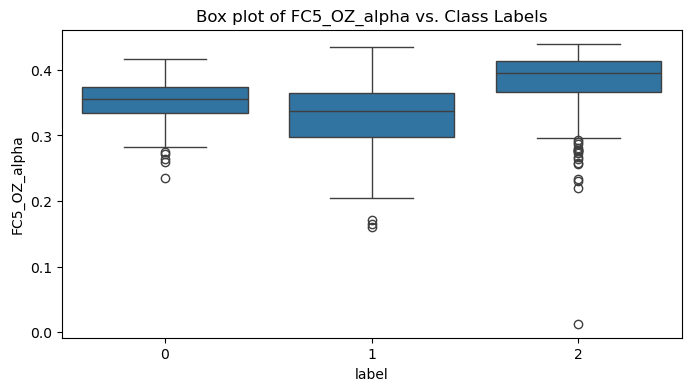

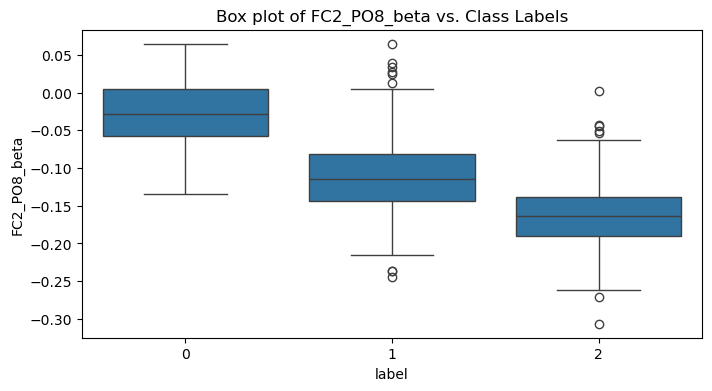

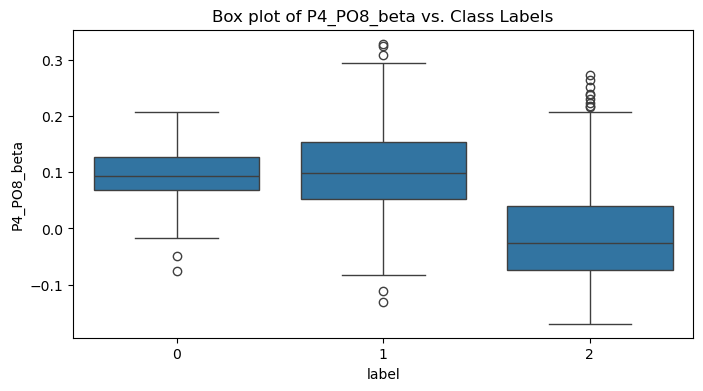

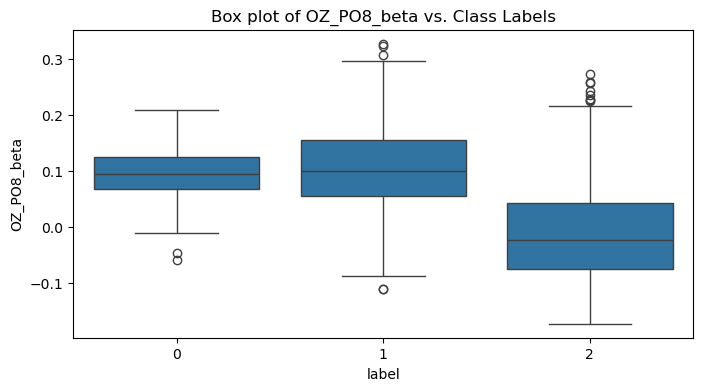

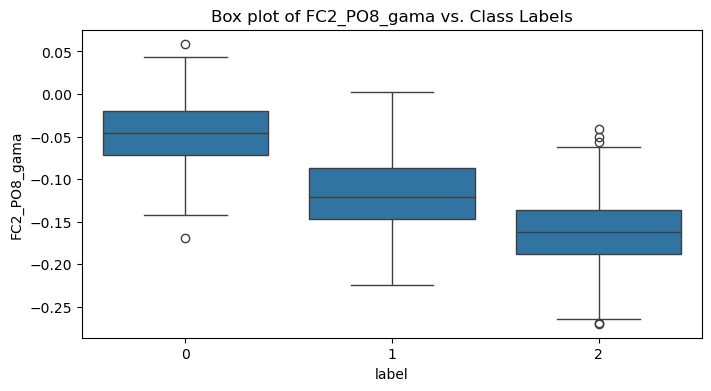

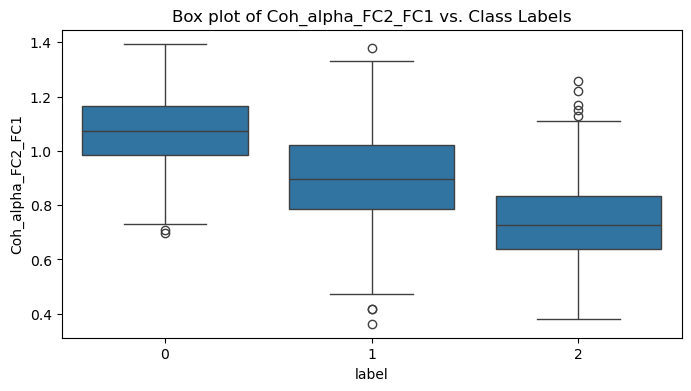

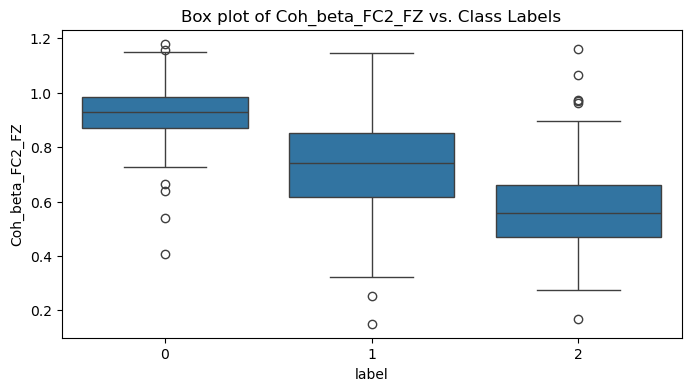

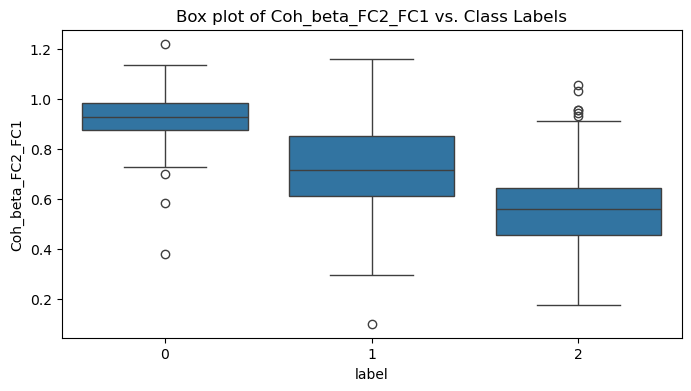

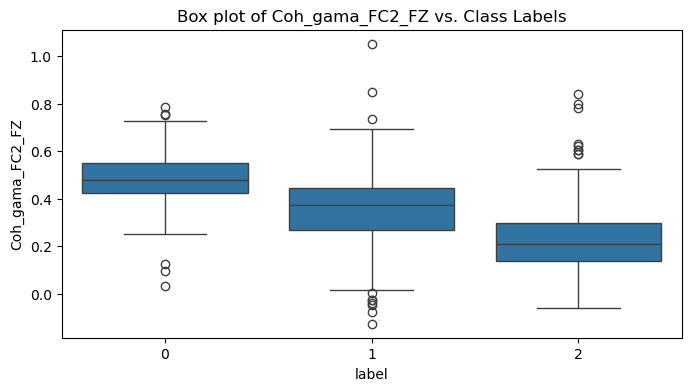

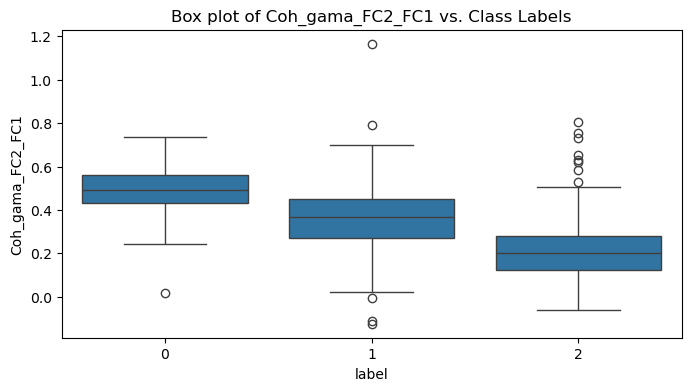

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your selected features in a DataFrame `selected_X` and `y` is the label
selected_features_df = Total_dataframe[selected_features]  # Use the selected features columns

# Combine features and labels for visualization
data = pd.concat([selected_features_df, y], axis=1)

# Create a boxplot for each feature against class labels
for feature in selected_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='label', y=feature, data=data)  # 'label' is the name of the class column
    plt.title(f'Box plot of {feature} vs. Class Labels')
    plt.show()

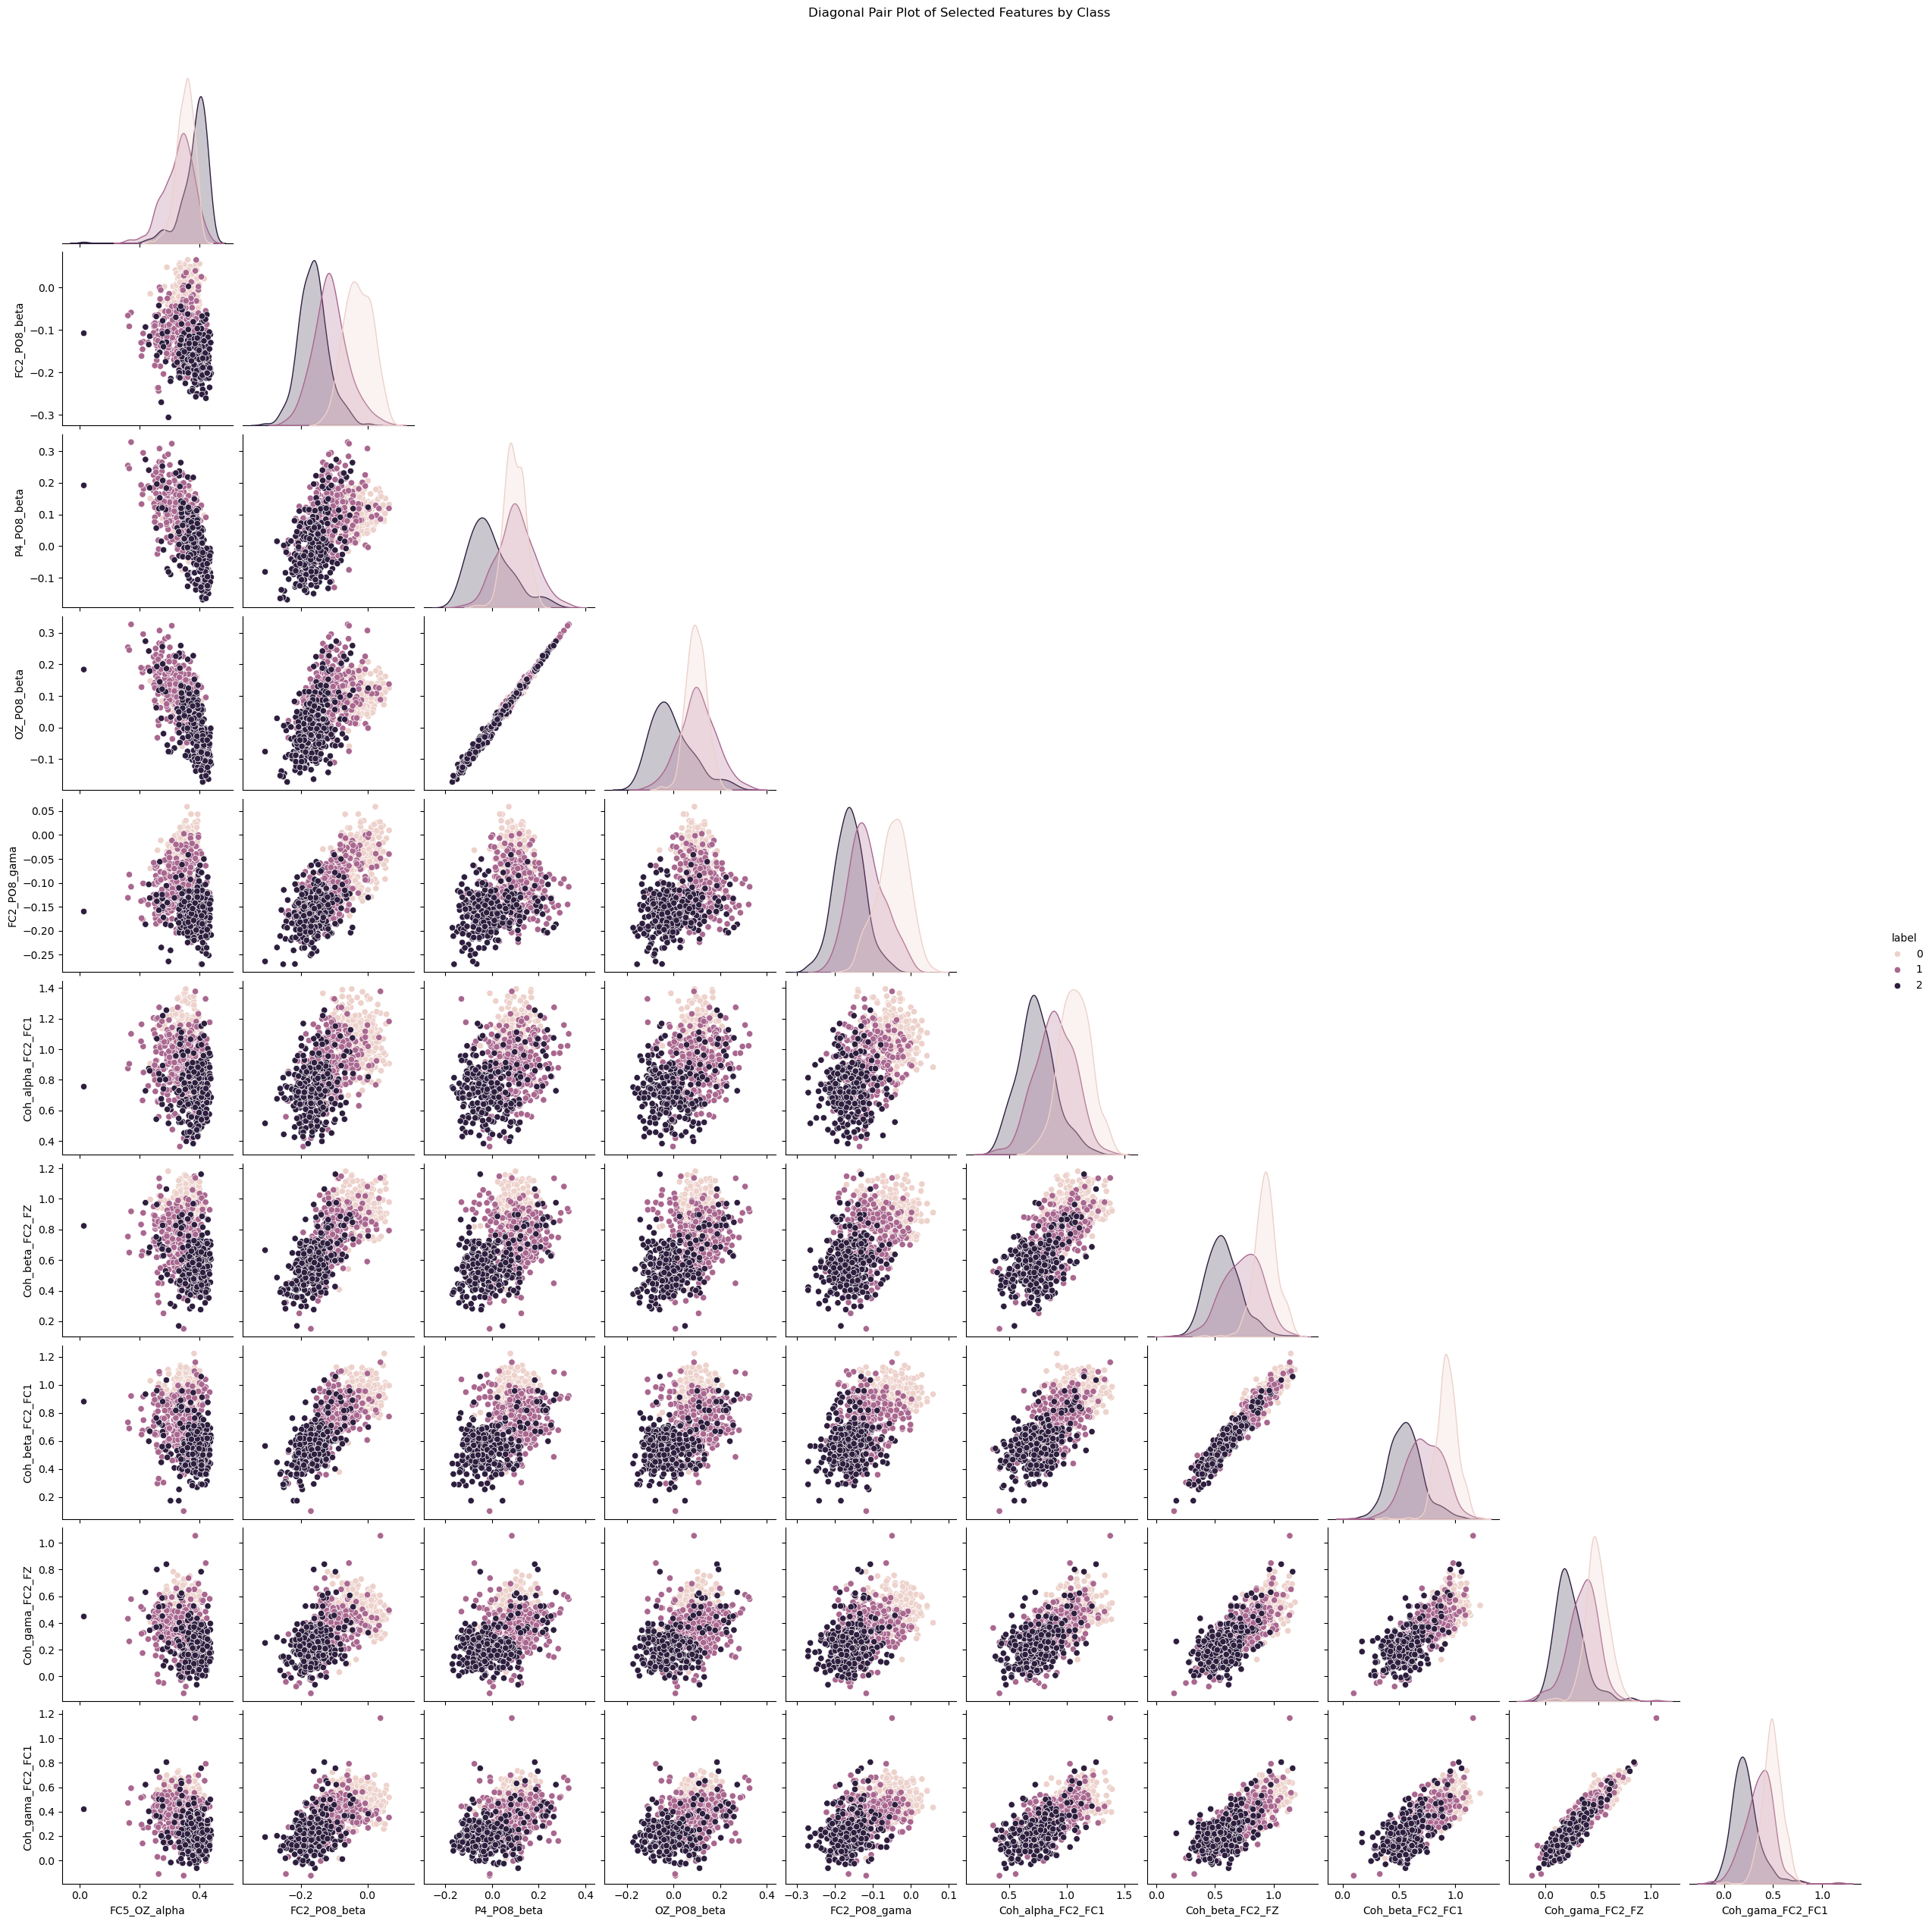

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame `data` containing your selected features and the labels
# Example: `data` has columns `selected_features` and `label` for class label

# Pairplot with only diagonal figures
sns.pairplot(data, hue='label', vars=selected_features, corner=True, diag_kind='kde')  # Use 'kde' for smooth distributions
plt.suptitle("Diagonal Pair Plot of Selected Features by Class", y=1.02)
plt.show()

In [ ]:
"""# Scatter plot between two selected features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=selected_features[0], y=selected_features[1], hue='label', data=data, palette='viridis')
plt.title(f'Scatter Plot of {selected_features[0]} vs {selected_features[1]}')
plt.show()"""

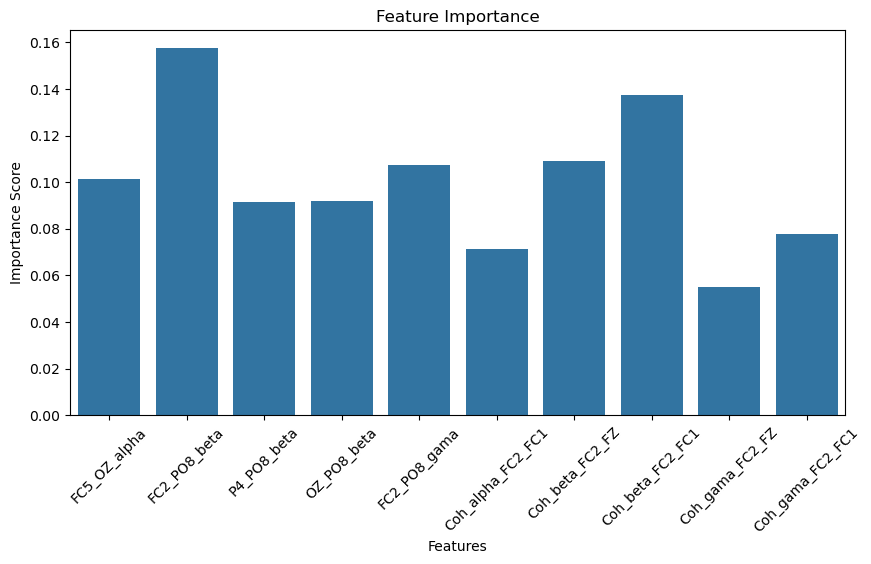

In [36]:
# If using a model like RandomForestClassifier
importances = selector.estimator_.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=selected_features, y=importances)
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

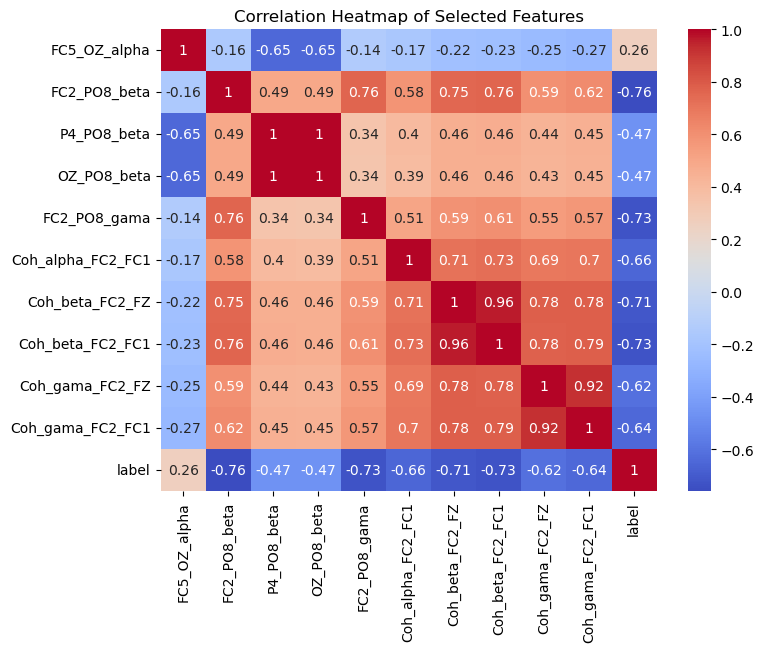

In [38]:
# Compute the correlation matrix
correlation = data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

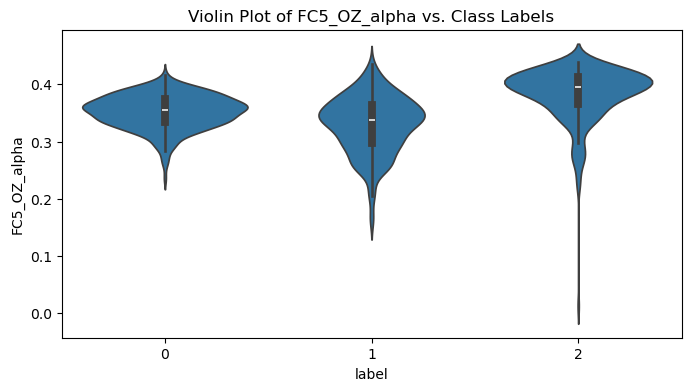

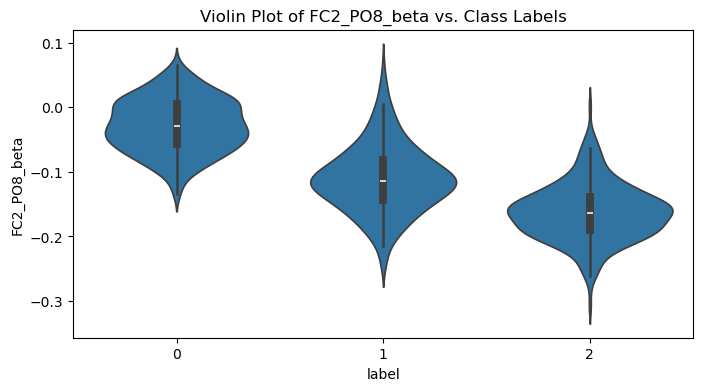

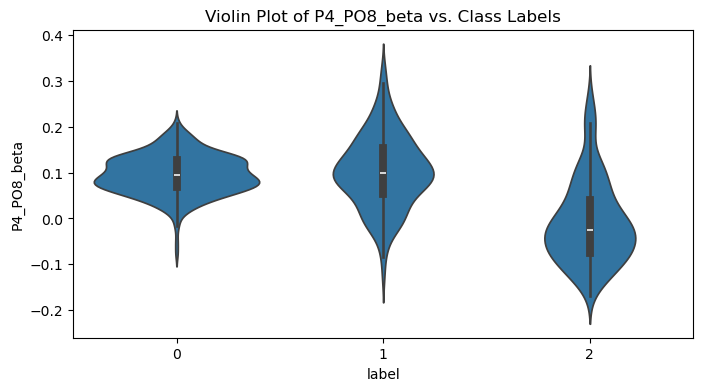

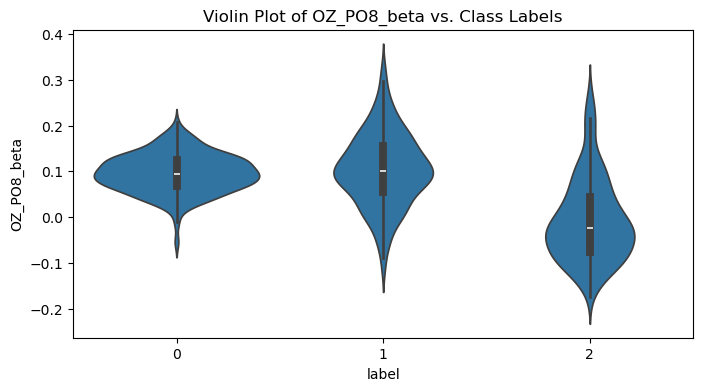

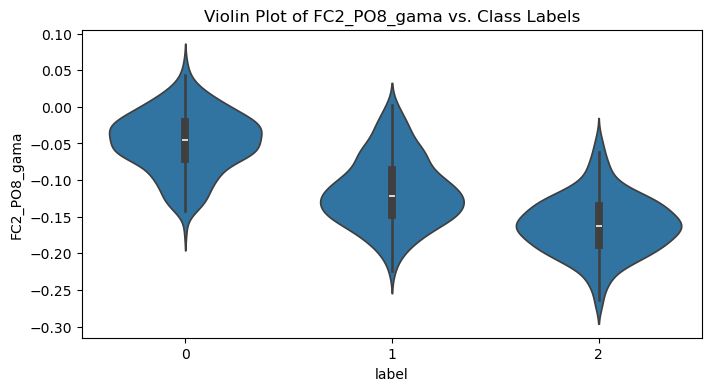

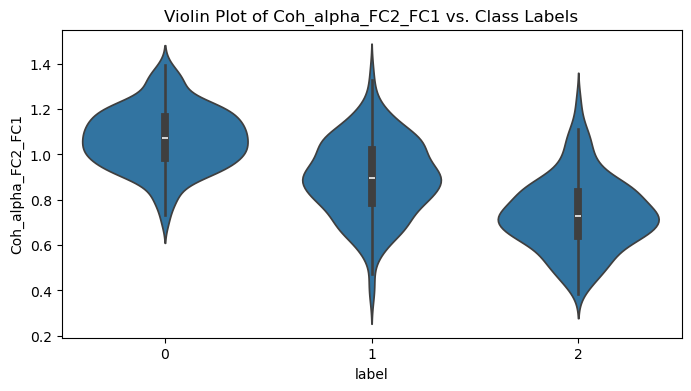

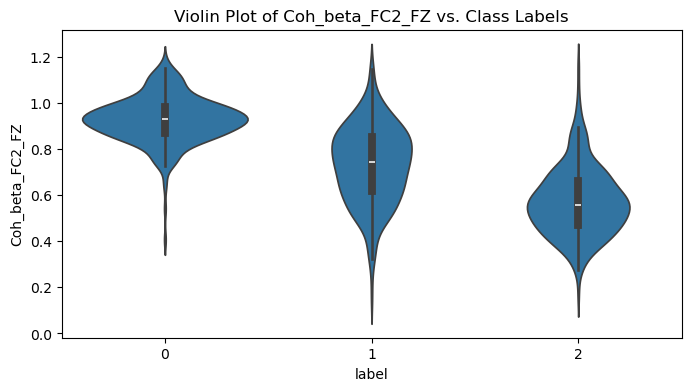

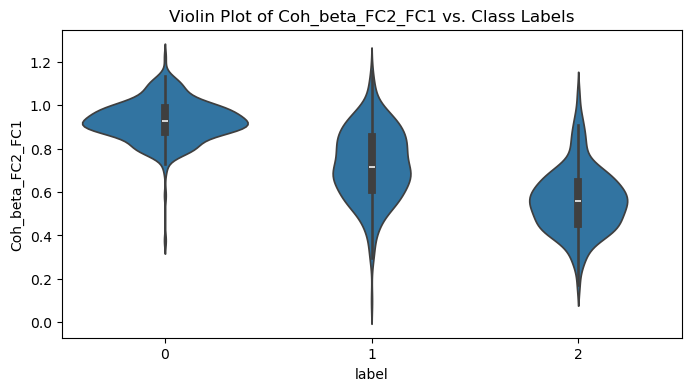

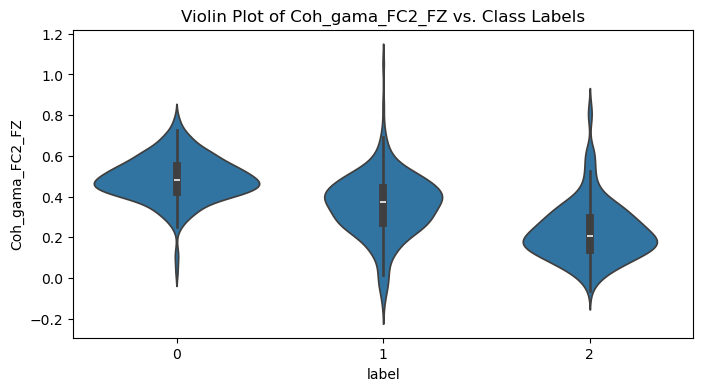

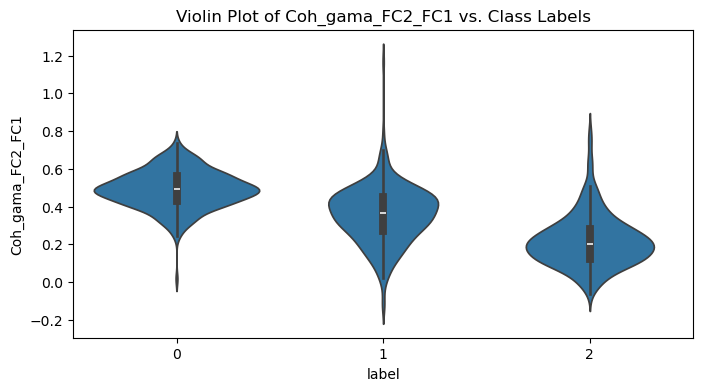

In [40]:
# Violin plot for each feature
for feature in selected_features:
    plt.figure(figsize=(8, 4))
    sns.violinplot(x='label', y=feature, data=data)
    plt.title(f'Violin Plot of {feature} vs. Class Labels')
    plt.show()

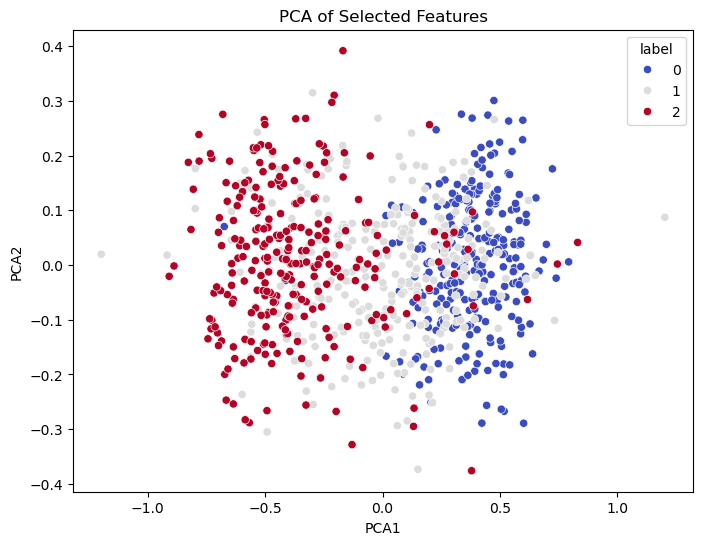

In [42]:
from sklearn.decomposition import PCA

# Apply PCA on the selected features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(selected_features_df)

# Create a DataFrame to plot the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['label'] = y.values

# Plot the PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=pca_df, palette='coolwarm')
plt.title('PCA of Selected Features')
plt.show()